Run all pour avoir les bons poids dans chaque réseau
----------------------------------------------------

In [1]:
from keras.utils import load_img, img_to_array
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.optimizers import SGD
from keras.models import load_model
from keras.models import Sequential
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
from sklearn.metrics import classification_report
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import shap

C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://

In [2]:
num_classes = 3
# First trying with low resolution
input_shape = 32

In [3]:
def load(image_paths, image_size, verbose = -1):

    data, labels = [], []

    for (i, path) in enumerate(image_paths):
        image = cv2.imread(path)
        label = path.split("\\")[-2]
        image = cv2.resize(image, (image_size, image_size))
        data.append(image)
        labels.append(label)

        if verbose > 0 and (i+1) % verbose == 0:
            print("[INFO] loading image {}/{}...".format(i+1, len(image_paths)))
    
    return (np.array(data), np.array(labels))

In [4]:
# Shortened version of AlexNet implemented in keras
def create_AlexNet(input_shape, num_classes):

    net = Sequential()
    net.add(Conv2D(filters=96,kernel_size=(3,3),strides=(4,4),input_shape=(input_shape, input_shape, 3), activation='relu'))
    net.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    net.add(Conv2D(256,(5,5),padding='same',activation='relu'))
    net.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    net.add(Conv2D(384,(3,3),padding='same',activation='relu'))
    net.add(Conv2D(384,(3,3),padding='same',activation='relu'))
    net.add(Conv2D(256,(3,3),padding='same',activation='relu'))
    net.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

    net.add(Flatten())
    net.add(Dense(4096, activation='relu'))
    net.add(Dropout(0.4))
    net.add(Dense(1024, activation='relu'))
    net.add(Dropout(0.4))
    net.add(Dense(num_classes,activation='softmax'))

    net.compile(optimizer = keras.optimizers.SGD(learning_rate = 0.01),
                            loss = "categorical_crossentropy", metrics = ["accuracy"])
    
    return net

In [5]:
animalsPaths = list(paths.list_images("..\\animals\\"))
data_animals, labels_animals = load(animalsPaths, image_size = input_shape, verbose = 500)

[INFO] loading image 500/3000...
[INFO] loading image 1000/3000...
[INFO] loading image 1500/3000...
[INFO] loading image 2000/3000...
[INFO] loading image 2500/3000...
[INFO] loading image 3000/3000...


In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_animals, labels_animals, 
                                            test_size = 0.20, random_state = 42)

X_train = X_train.astype("float") / 255.0
X_test = X_test.astype("float") / 255.0

y_train = LabelBinarizer().fit_transform(y_train)
y_test = LabelBinarizer().fit_transform(y_test)

Shortened version of AlexNet   
----------------------------

In [7]:
network = create_AlexNet(input_shape, num_classes)

Epoch 1/12
75/75 [==============================] - 23s 295ms/step - loss: 1.0987 - accuracy: 0.3363 - val_loss: 1.0988 - val_accuracy: 0.3100
Epoch 2/12
75/75 [==============================] - 21s 275ms/step - loss: 1.0981 - accuracy: 0.3508 - val_loss: 1.0987 - val_accuracy: 0.3100
Epoch 3/12
75/75 [==============================] - 21s 277ms/step - loss: 1.0979 - accuracy: 0.3733 - val_loss: 1.0985 - val_accuracy: 0.3100
Epoch 4/12
75/75 [==============================] - 21s 286ms/step - loss: 1.0975 - accuracy: 0.3458 - val_loss: 1.0979 - val_accuracy: 0.4067
Epoch 5/12
75/75 [==============================] - 21s 275ms/step - loss: 1.0968 - accuracy: 0.4025 - val_loss: 1.0974 - val_accuracy: 0.3217
Epoch 6/12
75/75 [==============================] - 21s 276ms/step - loss: 1.0962 - accuracy: 0.3775 - val_loss: 1.0965 - val_accuracy: 0.3833
Epoch 7/12
75/75 [==============================] - 21s 274ms/step - loss: 1.0956 - accuracy: 0.3992 - val_loss: 1.0957 - val_accuracy: 0.4300

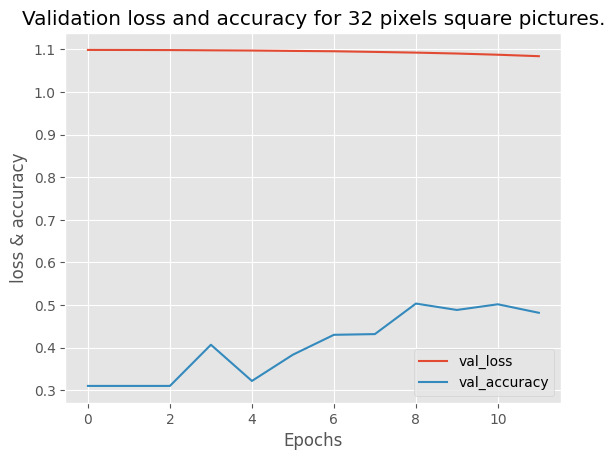

In [8]:
H = network.fit(X_train, y_train, validation_data = (X_test, y_test),
              batch_size = 32, epochs = 12)

networkSavePath = "AlexNet_Animals.keras"
network.save(networkSavePath)

plt.figure()
plt.style.use("ggplot")
plt.plot(np.arange(0, 12), H.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, 12), H.history["val_accuracy"], label = "val_accuracy")
plt.title("Validation loss and accuracy for {} pixels square pictures.".format(input_shape))
plt.xlabel("Epochs")
plt.ylabel("loss & accuracy")
plt.legend()
plt.show()

In [9]:
imagesPaths = list(paths.list_images("..\\images\\"))
data_images, labels_images = load(imagesPaths, image_size = input_shape)

data_images = data_images.astype("float") / 255.0

labels_images_binarized = LabelBinarizer().fit_transform(labels_images)
print(labels_images)

['cat' 'dog' 'panda']


In [10]:
predictions_images = network.predict(data_images)
print(classification_report(labels_images_binarized.argmax(axis = 0), 
                        predictions_images.argmax(axis = 0), target_names = labels_images))

1/1 [==============================] - 0s 303ms/step
              precision    recall  f1-score   support

         cat       0.00      0.00      0.00         1
         dog       0.00      0.00      0.00         1
       panda       1.00      1.00      1.00         1

    accuracy                           0.33         3
   macro avg       0.33      0.33      0.33         3
weighted avg       0.33      0.33      0.33         3



In [11]:
print(predictions_images)

[[0.3366642  0.34338173 0.31995407]
 [0.33676767 0.34331113 0.31992117]
 [0.3114415  0.32361254 0.36494598]]


In [12]:
reduced_X_train = X_train[np.random.choice(X_train.shape[0], 300, replace = False)]

In [13]:
exp = shap.GradientExplainer(network, reduced_X_train)

In [14]:
shap_values_images = exp.shap_values(data_images)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [15]:
labels_images_shap = np.array([labels_images for i in range(len(shap_values_images))])
print(labels_images_shap)

true_labels_images = [f"true: {a} - predicted: {labels_images[b.argmax(axis = 0)]}" 
                        for (a, b) in zip(labels_images, predictions_images)]
print(true_labels_images)

[['cat' 'dog' 'panda']
 ['cat' 'dog' 'panda']
 ['cat' 'dog' 'panda']]
['true: cat - predicted: dog', 'true: dog - predicted: dog', 'true: panda - predicted: panda']


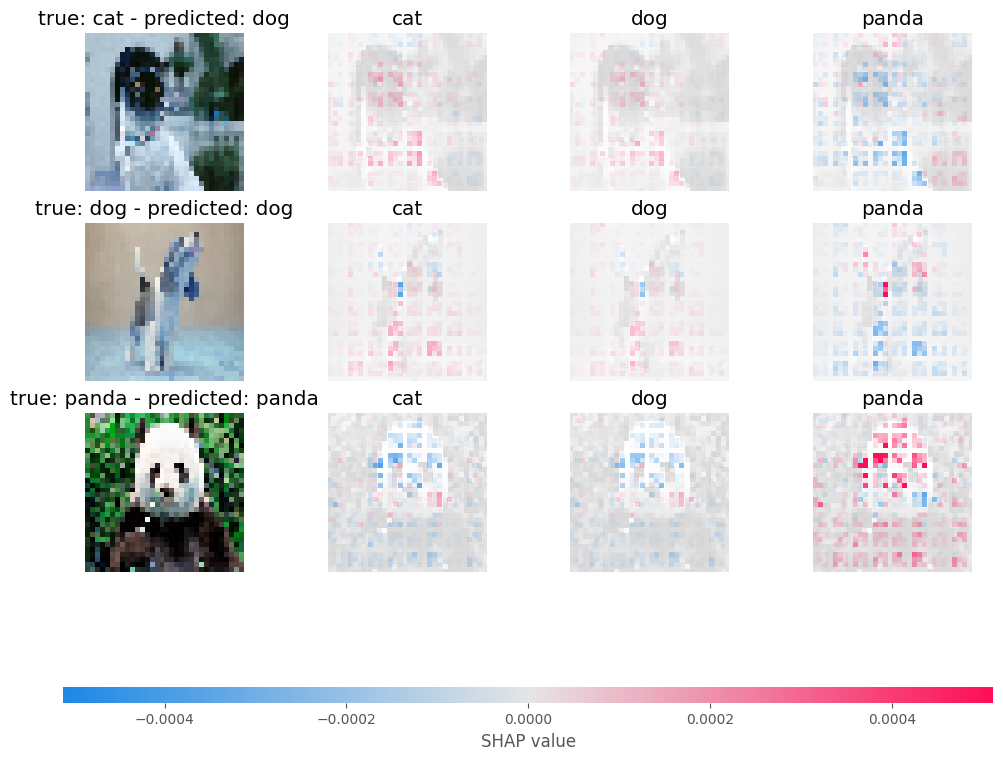

In [16]:
shap.plots.image(shap_values = shap_values_images, pixel_values = data_images,
                 labels = labels_images_shap, true_labels = true_labels_images)

Image resolution is too low for the model to learn anything.   
We can see a pattern starting to appear for panda class.

In [17]:
# Trying with higher resolution
input_shape_2 = 64

network_2 = create_AlexNet(input_shape = input_shape_2, num_classes = num_classes)

In [18]:
data_animals_2, labels_animals_2 = load(animalsPaths, image_size = input_shape_2,
                                        verbose = 500)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(data_animals_2, labels_animals_2,
                                                    test_size = 0.20, random_state = 42)

X_train_2 = X_train_2.astype("float") / 255.0
X_test_2 = X_test_2.astype("float") / 255.0

y_train_2 = LabelBinarizer().fit_transform(y_train_2)
y_test_2 = LabelBinarizer().fit_transform(y_test_2)

[INFO] loading image 500/3000...
[INFO] loading image 1000/3000...
[INFO] loading image 1500/3000...
[INFO] loading image 2000/3000...
[INFO] loading image 2500/3000...
[INFO] loading image 3000/3000...


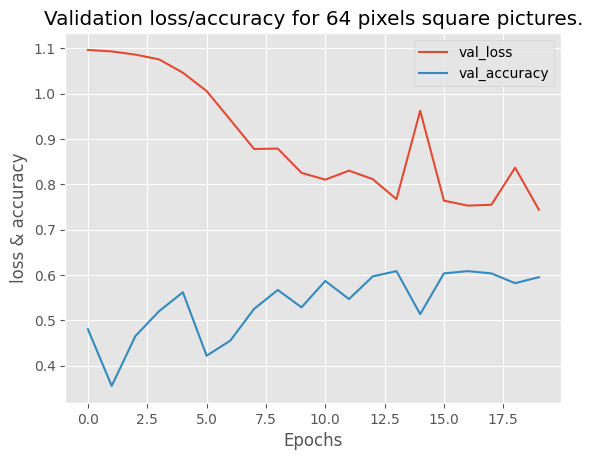

In [63]:
# H_2 = network_2.fit(X_train_2, y_train_2,
#                     validation_data = (X_test_2, y_test_2), epochs = 20)
# network2SavePath = "AlexNet_2_Animals.keras"
# network_2.save(network2SavePath)

plt.figure()
plt.style.use("ggplot")
plt.plot(np.arange(0, 20), H_2.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, 20), H_2.history["val_accuracy"], label = "val_accuracy")
plt.title("Validation loss/accuracy for {} pixels square pictures.".format(input_shape_2))
plt.xlabel("Epochs")
plt.ylabel("loss & accuracy")
plt.legend()
plt.show()

In [20]:
data_images_2, labels_images_2 = load(image_paths = imagesPaths, 
                                    image_size = input_shape_2)

data_images_2 = data_images_2.astype("float") / 255.0

labels_images_2_binarized = LabelBinarizer().fit_transform(labels_images_2)

In [21]:
predictions_images_2 = network_2.predict(data_images_2)
print(classification_report(labels_images_2_binarized.argmax(axis = 0), 
                            predictions_images_2.argmax(axis = 0), 
                            target_names = labels_images_2))

1/1 [==============================] - 0s 264ms/step
              precision    recall  f1-score   support

         cat       0.00      0.00      0.00         1
         dog       0.00      0.00      0.00         1
       panda       1.00      1.00      1.00         1

    accuracy                           0.33         3
   macro avg       0.33      0.33      0.33         3
weighted avg       0.33      0.33      0.33         3



In [22]:
print(predictions_images_2)

[[0.46904197 0.51456654 0.01639142]
 [0.5191612  0.4661646  0.01467418]
 [0.00240591 0.00525324 0.9923409 ]]


In [23]:
reduced_X_train_2 = X_train_2[np.random.choice(X_train_2.shape[0],
                                               300, replace = False)]

In [24]:
exp_2 = shap.GradientExplainer(network_2, reduced_X_train_2)

In [25]:
shap_values_images_2 = exp_2.shap_values(data_images_2)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [26]:
true_labels_images_2 = [f"true: {a} - predicted: {labels_images_2[b.argmax(axis = 0)]}" 
                        for (a, b) in zip(labels_images_2, predictions_images_2)]
print(true_labels_images_2)

labels_images_2_shap = np.array([labels_images_2 for i in range(len(shap_values_images_2))])
print(labels_images_2_shap)

['true: cat - predicted: dog', 'true: dog - predicted: cat', 'true: panda - predicted: panda']
[['cat' 'dog' 'panda']
 ['cat' 'dog' 'panda']
 ['cat' 'dog' 'panda']]


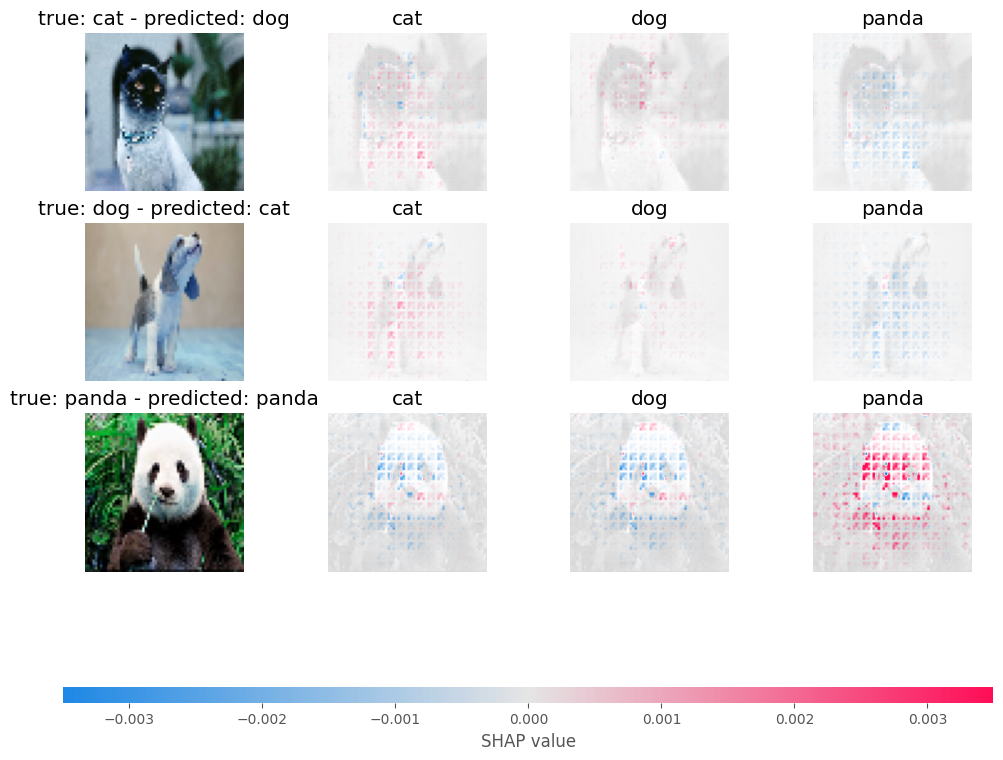

In [27]:
shap.plots.image(shap_values = shap_values_images_2, pixel_values = data_images_2,
                  labels = labels_images_2_shap, true_labels = true_labels_images_2)

Pixels' contribution to prediction are becoming very consistent for panda class, but remain mixed up for dog and cat classes.   
This might be due to the quality of our network.

More accurate AlexNet based network
-----------------------------------

In [28]:
def AlexNet(input_shape=(224,224,3), num_classes=20, dropout=False, batch_normalization=False):
    
    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(filters=48, input_shape=input_shape, kernel_size=(7,7), strides=(4,4), padding='valid'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    if(batch_normalization):
        model.add(BatchNormalization())

    # 2nd Convolutional Layer
    model.add(Conv2D(filters=128, kernel_size=(7,7), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    if(batch_normalization):
        model.add(BatchNormalization())

    # 3rd Convolutional Layer
    model.add(Conv2D(filters=197, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    if(batch_normalization):
        model.add(BatchNormalization())

    # 4th Convolutional Layer
    model.add(Conv2D(filters=197, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    if(batch_normalization):
        model.add(BatchNormalization())

    # 5th Convolutional Layer
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    if(batch_normalization):
        model.add(BatchNormalization())

    # Passing it to a dense layer
    model.add(Flatten())
    model.add(Dense(4096, input_shape=(224*224*3,)))
    model.add(Activation('relu'))
    if(dropout):
        model.add(Dropout(0.4))
    if(batch_normalization):
        model.add(BatchNormalization())

    # 2nd Dense Layer
    model.add(Dense(1000))
    model.add(Activation('relu'))
    if(dropout):
        model.add(Dropout(0.4))
    if(batch_normalization):
        model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(optimizer = keras.optimizers.SGD(learning_rate = 0.01),
                  loss = "categorical_crossentropy", metrics = ["accuracy"])

    return model

In [29]:
input_shape_3 = 224

In [30]:
network_3 = AlexNet(input_shape = (input_shape_3, input_shape_3, 3), num_classes = 3,
                    dropout = True)

In [31]:
data_animals_3, labels_animals_3 = load(image_paths = animalsPaths, 
                                    image_size = input_shape_3, verbose = 500)

labels_animals_3_binarized = LabelBinarizer().fit_transform(labels_animals_3)

[INFO] loading image 500/3000...
[INFO] loading image 1000/3000...
[INFO] loading image 1500/3000...
[INFO] loading image 2000/3000...
[INFO] loading image 2500/3000...
[INFO] loading image 3000/3000...


In [32]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(data_animals_3, labels_animals_3, 
                                        test_size = 0.20, random_state = 42)

X_train_3 = X_train_3.astype("float") / 255.0
X_test_3 = X_test_3.astype("float") / 255.0

y_train_3 = LabelBinarizer().fit_transform(y_train_3)
y_test_3 = LabelBinarizer().fit_transform(y_test_3)

Epoch 1/20
75/75 [==============================] - 60s 786ms/step - loss: 1.0958 - accuracy: 0.3762 - val_loss: 1.0931 - val_accuracy: 0.3217
Epoch 2/20
75/75 [==============================] - 41s 546ms/step - loss: 1.0830 - accuracy: 0.4350 - val_loss: 1.0668 - val_accuracy: 0.4200
Epoch 3/20
75/75 [==============================] - 42s 561ms/step - loss: 1.0274 - accuracy: 0.4708 - val_loss: 0.9348 - val_accuracy: 0.5150
Epoch 4/20
75/75 [==============================] - 42s 556ms/step - loss: 0.9578 - accuracy: 0.5008 - val_loss: 0.9494 - val_accuracy: 0.4850
Epoch 5/20
75/75 [==============================] - 42s 556ms/step - loss: 0.9012 - accuracy: 0.5308 - val_loss: 0.8498 - val_accuracy: 0.5617
Epoch 6/20
75/75 [==============================] - 42s 565ms/step - loss: 0.8604 - accuracy: 0.5650 - val_loss: 0.8322 - val_accuracy: 0.5750
Epoch 7/20
75/75 [==============================] - 43s 578ms/step - loss: 0.8390 - accuracy: 0.5612 - val_loss: 0.8410 - val_accuracy: 0.5633

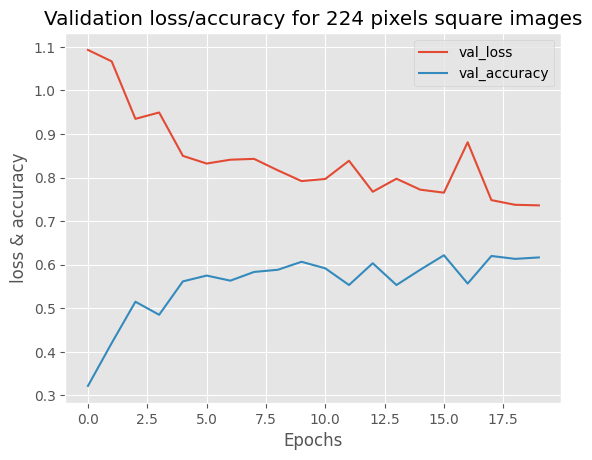

In [33]:
H_3 = network_3.fit(X_train_3, y_train_3, 
                    validation_data = (X_test_3, y_test_3), epochs = 20)

network3SavePath = "AlexNet_3_Animals.keras"
network_3.save(network3SavePath)

plt.figure()
plt.style.use("ggplot")
plt.plot(np.arange(0, 20), H_3.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, 20), H_3.history["val_accuracy"], label = "val_accuracy")
plt.title(f"Validation loss/accuracy for {input_shape_3} pixels square images")
plt.xlabel("Epochs")
plt.ylabel("loss & accuracy")
plt.legend()
plt.show()


In [34]:
data_images_3, labels_images_3 = load(image_paths = imagesPaths, 
                                    image_size = input_shape_3)

data_images_3 = data_images_3.astype("float") / 255.0

labels_images_3_binarized = LabelBinarizer().fit_transform(labels_images_3)

In [35]:
predictions_images_3 = network_3.predict(data_images_3)
print(classification_report(labels_images_3_binarized.argmax(axis = 0),
                            predictions_images_3.argmax(axis = 0),
                            target_names = labels_images_3))

1/1 [==============================] - 1s 525ms/step
              precision    recall  f1-score   support

         cat       0.00      0.00      0.00         1
         dog       0.00      0.00      0.00         1
       panda       1.00      1.00      1.00         1

    accuracy                           0.33         3
   macro avg       0.33      0.33      0.33         3
weighted avg       0.33      0.33      0.33         3



Predictions still wrong, might be caused by insufficient number of epochs

In [36]:
print(predictions_images_3)

[[0.566374   0.4165516  0.01707445]
 [0.5780898  0.4077797  0.01413056]
 [0.00637022 0.00543675 0.9881931 ]]


In [37]:
reduced_X_train_3 = X_train_3[np.random.choice(X_train_3.shape[0],
                                               300, replace = False)]

In [38]:
exp_3 = shap.GradientExplainer(network_3, reduced_X_train_3)

In [39]:
shap_values_images_3 = exp_3.shap_values(data_images_3)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [40]:
true_labels_images_3 = [f"true: {a} - predicted: {labels_images_3[b.argmax(axis = 0)]}" 
                        for (a, b) in zip(labels_images_3, predictions_images_3)]
print(true_labels_images_3)

labels_images_3_shap = np.array([labels_images_3 for i in range(len(shap_values_images_3))])
print(labels_images_3_shap)

['true: cat - predicted: cat', 'true: dog - predicted: cat', 'true: panda - predicted: panda']
[['cat' 'dog' 'panda']
 ['cat' 'dog' 'panda']
 ['cat' 'dog' 'panda']]


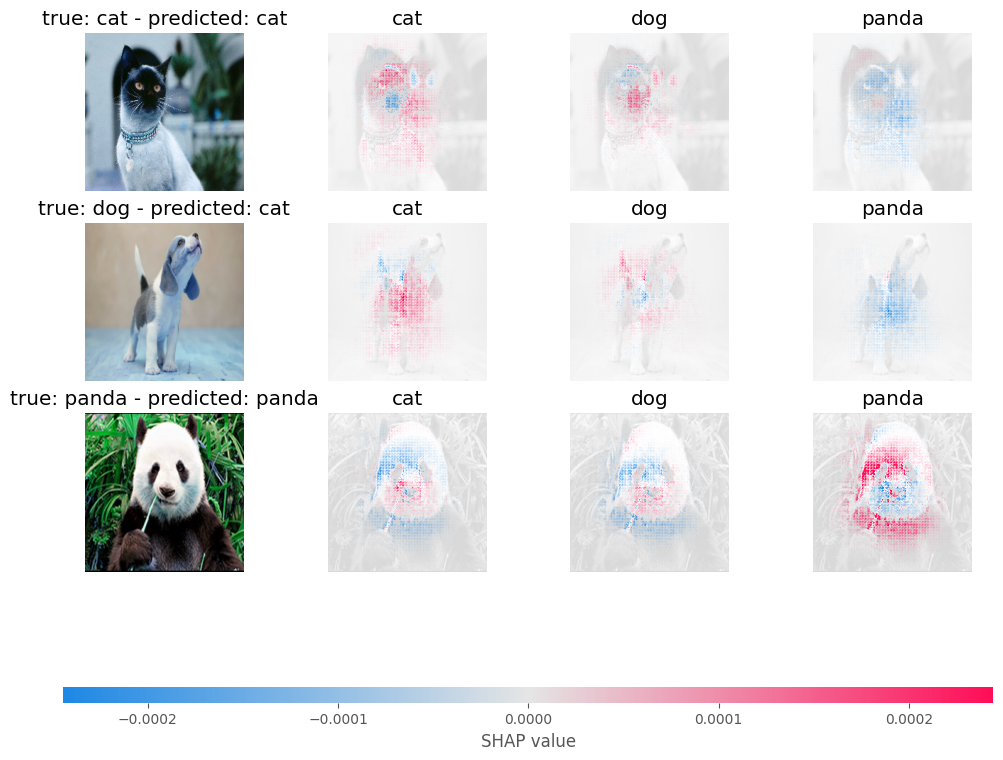

In [41]:
shap.plots.image(shap_values = shap_values_images_3, pixel_values = data_images_3,
                 labels = labels_images_3_shap, true_labels = true_labels_images_3)

Contributions make sense, but we can see some wrong pattern recognition made by the network for cat and dog classes. This might confirm the insufficient number of epochs.

In [50]:
# Trying with reduced size
input_shape_4 = 198

In [51]:
network_4 = AlexNet(input_shape = (input_shape_4, input_shape_4, 3), num_classes = 3,
                    dropout = True)

In [52]:
data_animals_4, labels_animals_4 = load(image_paths = animalsPaths, 
                                    image_size = input_shape_4, verbose = 500)

labels_animals_4_binarized = LabelBinarizer().fit_transform(labels_animals_4)

[INFO] loading image 500/3000...
[INFO] loading image 1000/3000...
[INFO] loading image 1500/3000...
[INFO] loading image 2000/3000...
[INFO] loading image 2500/3000...
[INFO] loading image 3000/3000...


In [53]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(data_animals_4, labels_animals_4, 
                                        test_size = 0.20, random_state = 42)

X_train_4 = X_train_4.astype("float") / 255.0
X_test_4 = X_test_4.astype("float") / 255.0

y_train_4 = LabelBinarizer().fit_transform(y_train_4)
y_test_4 = LabelBinarizer().fit_transform(y_test_4)

Epoch 1/20
75/75 [==============================] - 37s 474ms/step - loss: 1.0980 - accuracy: 0.3479 - val_loss: 1.0968 - val_accuracy: 0.4067
Epoch 2/20
75/75 [==============================] - 37s 495ms/step - loss: 1.0951 - accuracy: 0.4187 - val_loss: 1.0925 - val_accuracy: 0.4500
Epoch 3/20
75/75 [==============================] - 37s 492ms/step - loss: 1.0892 - accuracy: 0.4604 - val_loss: 1.0831 - val_accuracy: 0.4667
Epoch 4/20
75/75 [==============================] - 38s 510ms/step - loss: 1.0709 - accuracy: 0.4917 - val_loss: 1.0505 - val_accuracy: 0.4417
Epoch 5/20
75/75 [==============================] - 36s 476ms/step - loss: 0.9965 - accuracy: 0.5008 - val_loss: 1.0022 - val_accuracy: 0.4300
Epoch 6/20
75/75 [==============================] - 34s 458ms/step - loss: 0.9317 - accuracy: 0.4996 - val_loss: 0.8913 - val_accuracy: 0.5617
Epoch 7/20
75/75 [==============================] - 33s 437ms/step - loss: 0.9003 - accuracy: 0.5312 - val_loss: 0.8699 - val_accuracy: 0.5600

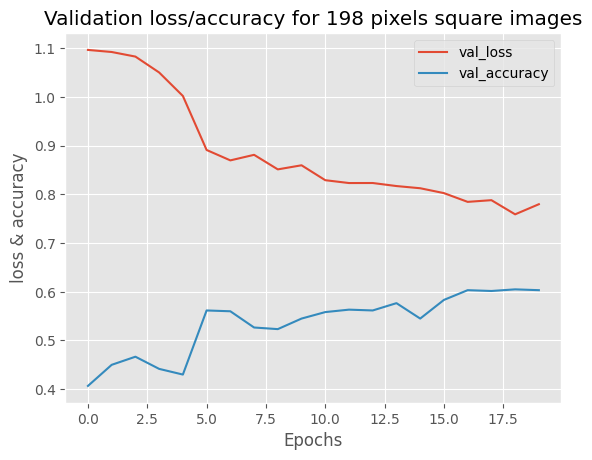

In [54]:
H_4 = network_4.fit(X_train_4, y_train_4, 
            validation_data = (X_test_4, y_test_4), epochs = 20)

network4SavePath = "AlexNet_3_Animals.keras"
network_4.save(network4SavePath)

plt.figure()
plt.style.use("ggplot")
plt.plot(np.arange(0, 20), H_4.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, 20), H_4.history["val_accuracy"], label = "val_accuracy")
plt.title(f"Validation loss/accuracy for {input_shape_4} pixels square images")
plt.xlabel("Epochs")
plt.ylabel("loss & accuracy")
plt.legend()
plt.show()


In [55]:
data_images_4, labels_images_4 = load(image_paths = imagesPaths, 
                                    image_size = input_shape_4)

data_images_4 = data_images_4.astype("float") / 255.0

labels_images_4_binarized = LabelBinarizer().fit_transform(labels_images_4)

In [56]:
predictions_images_4 = network_4.predict(data_images_4)
print(classification_report(labels_images_4_binarized.argmax(axis = 0),
                            predictions_images_4.argmax(axis = 0),
                            target_names = labels_images_4))

1/1 [==============================] - 0s 243ms/step
              precision    recall  f1-score   support

         cat       0.00      0.00      0.00         1
         dog       0.00      0.00      0.00         1
       panda       1.00      1.00      1.00         1

    accuracy                           0.33         3
   macro avg       0.33      0.33      0.33         3
weighted avg       0.33      0.33      0.33         3



In [57]:
print(predictions_images_4)

[[0.56182194 0.42984638 0.00833167]
 [0.5631065  0.42855817 0.00833532]
 [0.00573622 0.00597845 0.9882853 ]]


In [58]:
reduced_X_train_4 = X_train_4[np.random.choice(X_train_4.shape[0],
                                               300, replace = False)]

In [59]:
exp_4 = shap.GradientExplainer(network_4, reduced_X_train_4)

In [60]:
shap_values_images_4 = exp_4.shap_values(data_images_4)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [61]:
true_labels_images_4 = [f"true: {a} - predicted: {labels_images_4[b.argmax(axis = 0)]}" 
                        for (a, b) in zip(labels_images_4, predictions_images_4)]
print(true_labels_images_4)

labels_images_4_shap = np.array([labels_images_4 for i in range(len(shap_values_images_4))])
print(labels_images_4_shap)

['true: cat - predicted: cat', 'true: dog - predicted: cat', 'true: panda - predicted: panda']
[['cat' 'dog' 'panda']
 ['cat' 'dog' 'panda']
 ['cat' 'dog' 'panda']]


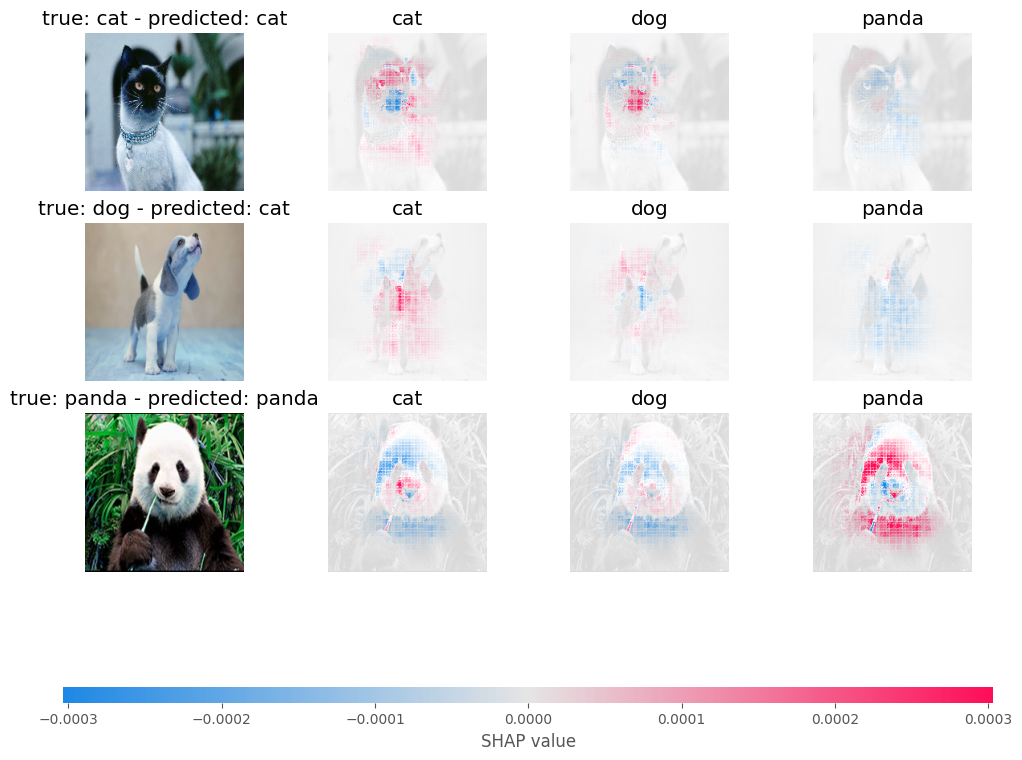

In [62]:
shap.plots.image(shap_values = shap_values_images_4, pixel_values = data_images_4,
                 labels = labels_images_4_shap, true_labels = true_labels_images_4)

Contribution not as accurate as they were for image_size == 224